# 一、GraphSAGE示例（深入浅出图神经网络）

In [28]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

def sampling(src_nodes, sample_num, neighbor_table):
    """根据源节点采样指定数量的邻居节点，注意使用的是有放回的采样；
    某个节点的邻居节点数量少于采样数量时，采样结果出现重复的节点
    Arguments:
        src_nodes {list, ndarray} -- 源节点列表
        sample_num {int} -- 需要采样的节点数
        neighbor_table {dict} -- 节点到其邻居节点的映射表，邻接矩阵
    Returns:
        np.ndarray -- 采样结果构成的列表
    """
    results = []
    for sid in src_nodes:
        # 从节点的邻居中进行有放回地进行采样 
        res = np.random.choice(neighbor_table[sid], size=(sample_num,))
        results.append(res)
    return np.asarray(results).flatten() #拉伸为1维
 
 
def multihop_sampling(src_nodes, sample_nums, neighbor_table):
    """根据源节点进行多阶采样
    Arguments:
        src_nodes {list, np.ndarray} -- 源节点id
        sample_nums {list of int} -- 每一阶需要采样的个数
        neighbor_table {dict} -- 节点到其邻居节点的映射 /邻接矩阵
    Returns:
        [list of ndarray] -- 每一阶采样的结果
    """
    sampling_result = [src_nodes] #首先包含源节点 
    for k, hopk_num in enumerate(sample_nums): #先对源节点进行1阶采样 在与源节点距离为1的节点中采样hopk_num个节点； 再对源节点进行2阶采样，即对源节点的所有1阶邻居进行1阶采样
        hopk_result = sampling(sampling_result[k], hopk_num, neighbor_table)
        sampling_result.append(hopk_result) #追加源节点的1阶邻居 和 2阶邻居(2层网络，代表采样到2阶)
    return sampling_result

class NeighborAggregator(nn.Module):
    def __init__(self, input_dim, output_dim,
                 use_bias=False, aggr_method="mean"):
        """聚合节点邻居
        Args:
            input_dim: 输入特征的维度
            output_dim: 输出特征的维度
            use_bias: 是否使用偏置 (default: {False})
            aggr_method: 邻居聚合方式 (default: {mean})
        """
        super(NeighborAggregator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.use_bias = use_bias
        self.aggr_method = aggr_method
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim))
        if self.use_bias:
            self.bias = nn.Parameter(torch.Tensor(self.output_dim))
        self.reset_parameters() #自定义参数初始化
 
    def reset_parameters(self):
        init.kaiming_uniform_(self.weight)
        if self.use_bias:
            init.zeros_(self.bias)
 
    def forward(self, neighbor_feature):
        if self.aggr_method == "mean":
            aggr_neighbor = neighbor_feature.mean(dim=1)
        elif self.aggr_method == "sum":
            aggr_neighbor = neighbor_feature.sum(dim=1)
        elif self.aggr_method == "max":
            aggr_neighbor = neighbor_feature.max(dim=1)
        else:
            raise ValueError("Unknown aggr type, expected sum, max, or mean, but got {}"
                             .format(self.aggr_method))
 
        neighbor_hidden = torch.matmul(aggr_neighbor, self.weight) #先聚合再做线性变换
        if self.use_bias:
            neighbor_hidden += self.bias
 
        return neighbor_hidden
 
    def extra_repr(self):
        return 'in_features={}, out_features={}, aggr_method={}'.format(
            self.input_dim, self.output_dim, self.aggr_method)

class SageGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim,
                 activation=F.relu,
                 aggr_neighbor_method="mean",
                 aggr_hidden_method="sum"):
        """SageGCN层定义
        Args:
            input_dim: 输入特征的维度
            hidden_dim: 隐层特征的维度，
                当aggr_hidden_method=sum, 输出维度为hidden_dim
                当aggr_hidden_method=concat, 输出维度为hidden_dim*2
            activation: 激活函数
            aggr_neighbor_method: 邻居特征聚合方法，["mean", "sum", "max"]
            aggr_hidden_method: 节点特征的更新方法，["sum", "concat"]
        """
        super(SageGCN, self).__init__()
        assert aggr_neighbor_method in ["mean", "sum", "max"]
        assert aggr_hidden_method in ["sum", "concat"]
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.aggr_neighbor_method = aggr_neighbor_method
        self.aggr_hidden_method = aggr_hidden_method
        self.activation = activation
        
        self.aggregator = NeighborAggregator(input_dim, hidden_dim,
                                             aggr_method=aggr_neighbor_method)
        self.weight = nn.Parameter(torch.Tensor(input_dim, hidden_dim))
        self.reset_parameters() #自定义参数初始化方式
 
    def reset_parameters(self):
        init.kaiming_uniform_(self.weight)
 
    def forward(self, src_node_features, neighbor_node_features):
        # 得到邻居节点的聚合特征(经过线性变换)
        neighbor_hidden = self.aggregator(neighbor_node_features)
        #对中心节点的特征作线性变换
        self_hidden = torch.matmul(src_node_features, self.weight)
 
        #对中心节点的特征和邻居节点的聚合特征进行求和或拼接
        if self.aggr_hidden_method == "sum":
            hidden = self_hidden + neighbor_hidden
        elif self.aggr_hidden_method == "concat":
            hidden = torch.cat([self_hidden, neighbor_hidden], dim=1)
        else:
            raise ValueError("Expected sum or concat, got {}"
                             .format(self.aggr_hidden))
        #通过激活函数
        if self.activation: 
            return self.activation(hidden)
        else:
            return hidden
 
    def extra_repr(self):
        output_dim = self.hidden_dim if self.aggr_hidden_method == "sum" else self.hidden_dim * 2
        return 'in_features={}, out_features={}, aggr_hidden_method={}'.format(
            self.input_dim, output_dim, self.aggr_hidden_method)

class GraphSage(nn.Module):
    def __init__(self, input_dim, hidden_dim,
                 num_neighbors_list):
        super(GraphSage, self).__init__()
        self.input_dim = input_dim     #1433
        self.hidden_dim = hidden_dim    #[128,7]
        self.num_neighbors_list = num_neighbors_list #[10,10] 两层 1阶节点采样10个 2阶节点采样10个
        self.num_layers = len(num_neighbors_list) #2层
        self.gcn = nn.ModuleList()
        self.gcn.append(SageGCN(input_dim, hidden_dim[0]))
        for index in range(0, len(hidden_dim) - 2):
            self.gcn.append(SageGCN(hidden_dim[index], hidden_dim[index + 1]))
        self.gcn.append(SageGCN(hidden_dim[-2], hidden_dim[-1], activation=None))
 
    def forward(self, node_features_list):
        hidden = node_features_list      #[[源节点对应的特征],[1阶邻居对应的特征],[2阶邻居对应的特征]]
        for l in range(self.num_layers):
            next_hidden = []
            gcn = self.gcn[l]
            for hop in range(self.num_layers - l):
                src_node_features = hidden[hop]   #源节点对应的特征  (batch_size,feature_size=1433)
                src_node_num = len(src_node_features) #batch_size
                neighbor_node_features = hidden[hop + 1] \
                    .view((src_node_num, self.num_neighbors_list[hop], -1)) #(batch_size*10,feature_size) -> (batch_size,10,feature_size)
                h = gcn(src_node_features, neighbor_node_features) #(batch_size,hidden_size=128)
                next_hidden.append(h)
            hidden = next_hidden
        return hidden[0]  #(batch_size,hidden_size=7)
 
    def extra_repr(self):
        return 'in_features={}, num_neighbors_list={}'.format(
            self.input_dim, self.num_neighbors_list
        )

import os
import os.path as osp
import pickle
import numpy as np
import itertools
import scipy.sparse as sp
import urllib
from collections import namedtuple
 
 
Data = namedtuple('Data', ['x', 'y', 'adjacency_dict',
                           'train_mask', 'val_mask', 'test_mask'])
 
 
class CoraData(object):
    download_url = "https://raw.githubusercontent.com/kimiyoung/planetoid/master/data"
    filenames = ["ind.cora.{}".format(name) for name in
                 ['x', 'tx', 'allx', 'y', 'ty', 'ally', 'graph', 'test.index']]
 
    def __init__(self, data_root="cora", rebuild=False):
        """Cora数据，包括数据下载，处理，加载等功能
        当数据的缓存文件存在时，将使用缓存文件，否则将下载、进行处理，并缓存到磁盘
        处理之后的数据可以通过属性 .data 获得，它将返回一个数据对象，包括如下几部分：
            * x: 节点的特征，维度为 2708 * 1433，类型为 np.ndarray
            * y: 节点的标签，总共包括7个类别，类型为 np.ndarray
            * adjacency_dict: 邻接信息，，类型为 dict
            * train_mask: 训练集掩码向量，维度为 2708，当节点属于训练集时，相应位置为True，否则False
            * val_mask: 验证集掩码向量，维度为 2708，当节点属于验证集时，相应位置为True，否则False
            * test_mask: 测试集掩码向量，维度为 2708，当节点属于测试集时，相应位置为True，否则False
        Args:
        -------
            data_root: string, optional
                存放数据的目录，原始数据路径: {data_root}/raw
                缓存数据路径: {data_root}/processed_cora.pkl
            rebuild: boolean, optional
                是否需要重新构建数据集，当设为True时，如果存在缓存数据也会重建数据
        """
        self.data_root = data_root
        save_file = osp.join(self.data_root, "processed_cora.pkl")
        if osp.exists(save_file) and not rebuild:
            print("Using Cached file: {}".format(save_file))
            self._data = pickle.load(open(save_file, "rb"))
        else:
            self.maybe_download()
            self._data = self.process_data()
            with open(save_file, "wb") as f:
                pickle.dump(self.data, f)
            print("Cached file: {}".format(save_file))
 
    @property
    def data(self):
        """返回Data数据对象，包括x, y, adjacency, train_mask, val_mask, test_mask"""
        return self._data
 
    def process_data(self):
        """
        处理数据，得到节点特征和标签，邻接矩阵，训练集、验证集以及测试集
        引用自：https://github.com/rusty1s/pytorch_geometric
        """
        print("Process data ...")
        _, tx, allx, y, ty, ally, graph, test_index = [self.read_data(
            osp.join(self.data_root, "raw", name)) for name in self.filenames]
        train_index = np.arange(y.shape[0])
        val_index = np.arange(y.shape[0], y.shape[0] + 500)
        sorted_test_index = sorted(test_index)
 
        x = np.concatenate((allx, tx), axis=0)
        y = np.concatenate((ally, ty), axis=0).argmax(axis=1)
 
        x[test_index] = x[sorted_test_index]
        y[test_index] = y[sorted_test_index]
        num_nodes = x.shape[0]
 
        train_mask = np.zeros(num_nodes, dtype=np.bool)
        val_mask = np.zeros(num_nodes, dtype=np.bool)
        test_mask = np.zeros(num_nodes, dtype=np.bool)
        train_mask[train_index] = True
        val_mask[val_index] = True
        test_mask[test_index] = True
        adjacency_dict = graph
        print("Node's feature shape: ", x.shape)
        print("Node's label shape: ", y.shape)
        print("Adjacency's shape: ", len(adjacency_dict))
        print("Number of training nodes: ", train_mask.sum())
        print("Number of validation nodes: ", val_mask.sum())
        print("Number of test nodes: ", test_mask.sum())
 
        return Data(x=x, y=y, adjacency_dict=adjacency_dict,
                    train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
 
    def maybe_download(self):
        save_path = os.path.join(self.data_root, "raw")
        for name in self.filenames:
            if not osp.exists(osp.join(save_path, name)):
                self.download_data(
                    "{}/{}".format(self.download_url, name), save_path)
 
    @staticmethod
    def build_adjacency(adj_dict):
        """根据邻接表创建邻接矩阵"""
        edge_index = []
        num_nodes = len(adj_dict)
        for src, dst in adj_dict.items():
            edge_index.extend([src, v] for v in dst)
            edge_index.extend([v, src] for v in dst)
        # 去除重复的边
        edge_index = list(k for k, _ in itertools.groupby(sorted(edge_index)))
        edge_index = np.asarray(edge_index)
        adjacency = sp.coo_matrix((np.ones(len(edge_index)),
                                   (edge_index[:, 0], edge_index[:, 1])),
                                  shape=(num_nodes, num_nodes), dtype="float32")
        return adjacency
 
    @staticmethod
    def read_data(path):
        """使用不同的方式读取原始数据以进一步处理"""
        name = osp.basename(path)
        if name == "ind.cora.test.index":
            out = np.genfromtxt(path, dtype="int64")
            return out
        else:
            out = pickle.load(open(path, "rb"), encoding="latin1")
            out = out.toarray() if hasattr(out, "toarray") else out
            return out
 
    @staticmethod
    def download_data(url, save_path):
        """数据下载工具，当原始数据不存在时将会进行下载"""
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        data = urllib.request.urlopen(url)
        filename = os.path.split(url)[-1]
 
        with open(os.path.join(save_path, filename), 'wb') as f:
            f.write(data.read())
 
        return True

"""
基于Cora的GraphSage示例
"""
import torch
 
import numpy as np
import torch.nn as nn
import torch.optim as optim

 
from collections import namedtuple
INPUT_DIM = 1433    # 输入维度 (节点/样本特征向量维度)
# Note: 采样的邻居阶数需要与GCN的层数保持一致
HIDDEN_DIM = [128, 7]   # 隐藏单元节点数  两层
NUM_NEIGHBORS_LIST = [10, 10]   # 每阶/每层采样邻居的节点数
assert len(HIDDEN_DIM) == len(NUM_NEIGHBORS_LIST)
 
BTACH_SIZE = 16     # 批处理大小
EPOCHS = 20
NUM_BATCH_PER_EPOCH = 20    # 每个epoch循环的批次数
LEARNING_RATE = 0.01    # 学习率
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
 
Data = namedtuple('Data', ['x', 'y', 'adjacency_dict',
                           'train_mask', 'val_mask', 'test_mask'])
 
data = CoraData().data #获取预处理数据
x = data.x / data.x.sum(1, keepdims=True)  # 归一化数据，使得每一行和为1
 
train_index = np.where(data.train_mask)[0] #训练节点/数据对应的索引
train_label = data.y[train_index] #训练节点/数据对应的标签
test_index = np.where(data.test_mask)[0] #测试节点/数据对应的索引
 
model = GraphSage(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM,
                  num_neighbors_list=NUM_NEIGHBORS_LIST).to(DEVICE)
print(model)
criterion = nn.CrossEntropyLoss().to(DEVICE) #多分类交叉熵损失函数
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=5e-4) #Adam优化器
 
 
def train():
    model.train() #训练模式
    for e in range(EPOCHS):
        for batch in range(NUM_BATCH_PER_EPOCH):
            batch_src_index = np.random.choice(train_index, size=(BTACH_SIZE,)) #随机选择BTACH_SIZE个训练节点 作为源节点
            batch_src_label = torch.from_numpy(train_label[batch_src_index]).long().to(DEVICE) #这些训练节点对应的标签
            
            #对源节点进行0-K阶(k等于网络层数 k=2)采样
            batch_sampling_result = multihop_sampling(batch_src_index, NUM_NEIGHBORS_LIST, data.adjacency_dict) #[[源节点索引列表],[源节点的1阶邻居索引]=10,[源节点的2阶邻居索引]=10]
            batch_sampling_x = [torch.from_numpy(x[idx]).float().to(DEVICE) for idx in batch_sampling_result] #获取采样的节点对应的特征向量
            batch_train_logits = model(batch_sampling_x) #获取模型的输出 (BATCH_SIZE,hidden_size[-1]=7)
            loss = criterion(batch_train_logits, batch_src_label)
            optimizer.zero_grad() #清空梯度
            loss.backward()  # 反向传播计算参数的梯度
            optimizer.step()  # 使用优化方法进行梯度更新
            print("Epoch {:03d} Batch {:03d} Loss: {:.4f}".format(e, batch, loss.item()))
        test() #每一epoch做一次测试
 
 
def test():
    model.eval() #测试模型
    with torch.no_grad():
        test_sampling_result = multihop_sampling(test_index, NUM_NEIGHBORS_LIST, data.adjacency_dict) #对测试节点进行0-K阶(k等于网络层数 k=2)采样[[测试节点索引列表],[源节点的1阶邻居索引]=10,[源节点的2阶邻居索引]=10]
        test_x = [torch.from_numpy(x[idx]).float().to(DEVICE) for idx in test_sampling_result]#获取采样的节点对应的特征向量
        test_logits = model(test_x) #得到模型输出 (len(test_index),hidden_size[-1]=7)
        test_label = torch.from_numpy(data.y[test_index]).long().to(DEVICE) #测试节点对应的标签
        predict_y = test_logits.max(1)[1] #预测标签 对预测结果按行取argmax
        accuarcy = torch.eq(predict_y, test_label).float().mean().item() #计算在测试节点/数据上的准确率
        print("Test Accuracy: ", accuarcy) 
 
 
if __name__ == '__main__':
    train()
 

Process data ...
Node's feature shape:  (2708, 1433)
Node's label shape:  (2708,)
Adjacency's shape:  2708
Number of training nodes:  140
Number of validation nodes:  500
Number of test nodes:  1000
Cached file: cora/processed_cora.pkl
GraphSage(
  in_features=1433, num_neighbors_list=[10, 10]
  (gcn): ModuleList(
    (0): SageGCN(
      in_features=1433, out_features=128, aggr_hidden_method=sum
      (aggregator): NeighborAggregator(in_features=1433, out_features=128, aggr_method=mean)
    )
    (1): SageGCN(
      in_features=128, out_features=7, aggr_hidden_method=sum
      (aggregator): NeighborAggregator(in_features=128, out_features=7, aggr_method=mean)
    )
  )
)
Epoch 000 Batch 000 Loss: 2.0557
Epoch 000 Batch 001 Loss: 1.8241


<ipython-input-28-5562b0da28ee>:250: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_mask = np.zeros(num_nodes, dtype=np.bool)
<ipython-input-28-5562b0da28ee>:251: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val_mask = np.zeros(num_nodes, dtype=np.bool)
<ipython-input-28-5562b0da28ee>:252: DeprecationWarning: `np.bool` is a deprecated alias f

Epoch 000 Batch 002 Loss: 1.7547
Epoch 000 Batch 003 Loss: 1.4892
Epoch 000 Batch 004 Loss: 1.6557
Epoch 000 Batch 005 Loss: 1.3986
Epoch 000 Batch 006 Loss: 1.7084
Epoch 000 Batch 007 Loss: 1.3037
Epoch 000 Batch 008 Loss: 1.2882
Epoch 000 Batch 009 Loss: 1.0936
Epoch 000 Batch 010 Loss: 0.9544
Epoch 000 Batch 011 Loss: 0.6381
Epoch 000 Batch 012 Loss: 0.7388
Epoch 000 Batch 013 Loss: 0.5383
Epoch 000 Batch 014 Loss: 0.6054
Epoch 000 Batch 015 Loss: 0.2675
Epoch 000 Batch 016 Loss: 0.4823
Epoch 000 Batch 017 Loss: 0.4416
Epoch 000 Batch 018 Loss: 0.3967
Epoch 000 Batch 019 Loss: 0.2728
Test Accuracy:  0.7680000066757202
Epoch 001 Batch 000 Loss: 0.2004
Epoch 001 Batch 001 Loss: 0.3883
Epoch 001 Batch 002 Loss: 0.5967
Epoch 001 Batch 003 Loss: 0.1380
Epoch 001 Batch 004 Loss: 0.1905
Epoch 001 Batch 005 Loss: 0.0764
Epoch 001 Batch 006 Loss: 0.1195
Epoch 001 Batch 007 Loss: 0.1253
Epoch 001 Batch 008 Loss: 0.0581
Epoch 001 Batch 009 Loss: 0.0301
Epoch 001 Batch 010 Loss: 0.2199
Epoch 00

# 二、PYG实现GraphSAGE
## （一）安装PYG

In [2]:
!apt install gcc-5 g++-5 -y

!ln -sf /usr/bin/gcc-5 /usr/bin/gcc
!ln -sf /usr/bin/g++-5 /usr/bin/g++

!export CPATH=/usr/local/cuda/include:$CPATH

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package g++-5 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source
However the following packages replace it:
  gcc-10-test-results gcc-9-test-results gcc-8-test-results gcc-7-test-results

Package gcc-5 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Package 'gcc-5' has no installation candidate
E: Package 'g++-5' has no installation candidate


In [3]:
!pip install torch-scatter
!pip install torch-sparse
!pip install torch-cluster
!pip install torch-spline-conv
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.1-cp310-cp310-linux_x86_64.whl size=489401 sha256=6ebba31097238105d985fd6b3f6b8cdc2ddff554009270f1700f809f96087838
  Stored in directory: /root/.cache/pip/wheels/ef/67/58/6566a3b61c6ec0f2ca0c2c324cd035ef2955601f0fb3197d5f
Successfully built torch-scatter
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.17-cp310-cp310-linux_x86_64.whl size=1078307 sha256=c39f9e63cd4fcbf00a80a144cfa6e76cfb78ef63e17f9819f4c99f283b2a6dbe
  Stored in directory: /root/.cache/pip/wheels/67/25/e7/037b58fa

## （二）导入相关库

In [4]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch_geometric.nn as pyg_nn
from torch_geometric.datasets import Planetoid

## （三）加载Cora数据集

In [21]:
# 1.加载Cora数据集，可用Citeseer、Pubmed替换
dataset = Planetoid(root='./data/Cora', name='Cora')

Processing...
Done!


## （四）定义GraphSAGE网络

In [22]:
# 2.定义GraphSAGE网络
class GraphSAGE(nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = pyg_nn.SAGEConv(num_node_features, 16)
        self.conv2 = pyg_nn.SAGEConv(16, num_classes)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)


## （四）定义模型

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 设备
epochs = 600 # 学习轮数
lr = 0.0003 # 学习率
num_node_features = dataset.num_node_features # 每个节点的特征数
num_classes = dataset.num_classes # 每个节点的类别数
data = dataset[0].to(device) # Cora的一张图

# 3.定义模型
model = GraphSAGE(num_node_features, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # 优化器
loss_function = nn.NLLLoss() # 损失函数

##（五）模型训练

In [24]:
# 训练模式
model.train()

for epoch in range(epochs):
    optimizer.zero_grad()
    pred = model(data)
    
    loss = loss_function(pred[data.train_mask], data.y[data.train_mask]) # 损失
    correct_count_train = pred.argmax(axis=1)[data.train_mask].eq(data.y[data.train_mask]).sum().item() # epoch正确分类数目
    acc_train = correct_count_train / data.train_mask.sum().item() # epoch训练精度
    
    loss.backward()
    optimizer.step()
    
    if epoch % 20 == 0:
        print("【EPOCH: 】%s" % str(epoch + 1))
        print('训练损失为：{:.4f}'.format(loss.item()), '训练精度为：{:.4f}'.format(acc_train))

print('【Finished Training！】')


【EPOCH: 】1
训练损失为：1.9477 训练精度为：0.1357
【EPOCH: 】21
训练损失为：1.8115 训练精度为：0.5571
【EPOCH: 】41
训练损失为：1.6592 训练精度为：0.6857
【EPOCH: 】61
训练损失为：1.4721 训练精度为：0.8000
【EPOCH: 】81
训练损失为：1.3157 训练精度为：0.8643
【EPOCH: 】101
训练损失为：1.1464 训练精度为：0.8786
【EPOCH: 】121
训练损失为：1.0334 训练精度为：0.8857
【EPOCH: 】141
训练损失为：0.8213 训练精度为：0.9500
【EPOCH: 】161
训练损失为：0.7378 训练精度为：0.9714
【EPOCH: 】181
训练损失为：0.6151 训练精度为：0.9714
【EPOCH: 】201
训练损失为：0.5778 训练精度为：0.9786
【EPOCH: 】221
训练损失为：0.4896 训练精度为：0.9929
【EPOCH: 】241
训练损失为：0.4041 训练精度为：0.9786
【EPOCH: 】261
训练损失为：0.3664 训练精度为：0.9929
【EPOCH: 】281
训练损失为：0.3507 训练精度为：0.9929
【EPOCH: 】301
训练损失为：0.3121 训练精度为：0.9929
【EPOCH: 】321
训练损失为：0.2583 训练精度为：1.0000
【EPOCH: 】341
训练损失为：0.2532 训练精度为：0.9929
【EPOCH: 】361
训练损失为：0.2095 训练精度为：0.9929
【EPOCH: 】381
训练损失为：0.2138 训练精度为：0.9857
【EPOCH: 】401
训练损失为：0.1826 训练精度为：1.0000
【EPOCH: 】421
训练损失为：0.1746 训练精度为：1.0000
【EPOCH: 】441
训练损失为：0.1504 训练精度为：1.0000
【EPOCH: 】461
训练损失为：0.1443 训练精度为：1.0000
【EPOCH: 】481
训练损失为：0.1359 训练精度为：1.0000
【EPOCH: 】501
训练损失为：0.1004 训练精度为

## （六）模型验证

In [25]:
from sklearn.metrics import f1_score
# 模型验证
model.eval()
pred = model(data)

# 训练集（使用了掩码）
correct_count_train = pred.argmax(axis=1)[data.train_mask].eq(data.y[data.train_mask]).sum().item()
acc_train = correct_count_train / data.train_mask.sum().item()
loss_train = loss_function(pred[data.train_mask], data.y[data.train_mask]).item()
pred_train = pred.argmax(axis=1)[data.train_mask]
y_train = data.y[data.train_mask]
f1_train = f1_score(pred_train.cpu(), y_train.cpu(), average='weighted')


# 测试集
correct_count_test = pred.argmax(axis=1)[data.test_mask].eq(data.y[data.test_mask]).sum().item()
acc_test = correct_count_test / data.test_mask.sum().item()
loss_test = loss_function(pred[data.test_mask], data.y[data.test_mask]).item()
pred_test = pred.argmax(axis=1)[data.test_mask]
y_test = data.y[data.test_mask]
f1_test = f1_score(pred_test.cpu(), y_test.cpu(), average='weighted')



print('Train Accuracy: {:.4f}'.format(acc_train), 'Train Loss: {:.4f}'.format(loss_train), 'Train f1_score: {:.4f}'.format(f1_train))
print('Test  Accuracy: {:.4f}'.format(acc_test), 'Test  Loss: {:.4f}'.format(loss_test), 'Train f1_score: {:.4f}'.format(f1_test))




Train Accuracy: 1.0000 Train Loss: 0.0267 Train f1_score: 1.0000
Test  Accuracy: 0.7720 Test  Loss: 0.7628 Train f1_score: 0.7701


## 画图

<ipython-input-27-a9a9b5cf62b2>:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


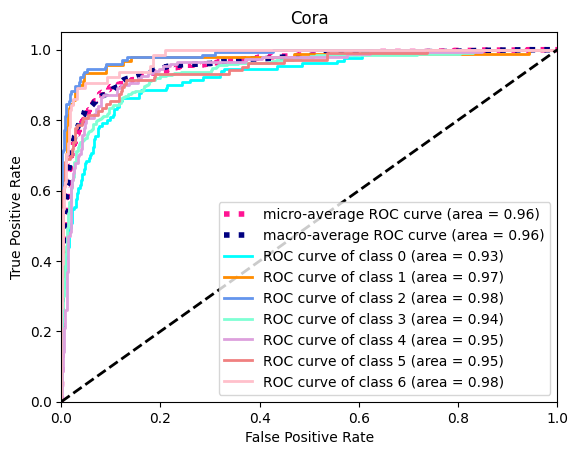

In [27]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize
from scipy import interp
import numpy as np
import matplotlib.pyplot as plt


y_test2 = label_binarize(y_test.cpu(), classes=[0, 1, 2, 3, 4, 5, 6])
pred_test2 = pred[data.test_mask]
n_classes = y_test2.shape[1]

# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test2[:, i], pred_test2[:, i].detach().numpy())
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area（方法二）
fpr["micro"], tpr["micro"], _ = roc_curve(y_test2.ravel(), pred_test2.detach().numpy().ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area（方法一）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw=2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'aquamarine', 'plum', 'lightcoral', 'pink'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cora')
plt.legend(loc="lower right")
plt.show()
